## 概要
適切に動作するノートブック

In [1]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import sklearn
print('sklearn version:', sklearn.__version__)

import warnings
warnings.filterwarnings('ignore')

import MeCab
tagger = MeCab.Tagger()

lightgbm version: 2.3.0
sklearn version: 0.22.1


/Users/endotakeru/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('input/train_data.csv')
test = pd.read_csv('input/test_data.csv')

In [3]:
# ↑のjsonファイルをnames.jsonで保存してある前提
with open("columns.json", "r", encoding="utf-8") as f:
     d = json.load(f)
        
train = train.rename(columns=d)
test = test.rename(columns=d)        

In [4]:
pub = pd.read_csv('./input/published_land_price.csv')

In [5]:
pair = {"所在地コード":"市区町村コード","建蔽率":"建ぺい率（％）","容積率":"容積率（％）","駅名":"最寄駅：名称", 
        "地積":"面積（㎡）","市区町村名":"市区町村名",'前面道路の幅員':'前面道路：幅員（ｍ）', 
        "前面道路の方位区分":"前面道路：方位","前面道路区分":"前面道路：種類","形状区分":"土地の形状",
        "用途区分":"都市計画"
         }

In [6]:
pub = pub.rename(columns=pair)

In [7]:
pub = pub.rename(columns=d)

In [8]:
pub.columns[:100]

Index(['id', '経度', '緯度', 'MunicipalityCode', 'Use', '連番', '年次', '前年所在地コード',
       '前年用途', '前年連番', 'Municipality', '住居表示', '行政', 'Area', '利用の現況', '利用状況表示',
       '建物構造', '施設', 'LandShape', '間口（比率）', '奥行（比率）', '階層（地上）', '階層（地下）',
       'Classification', 'Direction', 'Breadth', '前面道路の駅前区分', '前面道路の舗装状況',
       '側道区分', '側道方位区分', '交通施設との近接区分', '周辺の土地の利用の現況', 'NearestStation', '駅距離',
       'CityPlanning', '防火区分', '都市計画区分', '森林区分', '公園区分', 'CoverageRatio',
       'FloorAreaRatio', '共通地点区分', '選定年次ビット', 'Ｓ５８価格', 'Ｓ５９価格', 'Ｓ６０価格',
       'Ｓ６１価格', 'Ｓ６２価格', 'Ｓ６３価格', 'Ｈ１価格', 'Ｈ２価格', 'Ｈ３価格', 'Ｈ４価格', 'Ｈ５価格',
       'Ｈ６価格', 'Ｈ７価格', 'Ｈ８価格', 'Ｈ９価格', 'Ｈ１０価格', 'Ｈ１１価格', 'Ｈ１２価格', 'Ｈ１３価格',
       'Ｈ１４価格', 'Ｈ１５価格', 'Ｈ１６価格', 'Ｈ１７価格', 'Ｈ１８価格', 'Ｈ１９価格', 'Ｈ２０価格', 'Ｈ２１価格',
       'Ｈ２２価格', 'Ｈ２３価格', 'Ｈ２４価格', 'Ｈ２５価格', 'Ｈ２６価格', 'Ｈ２７価格', 'Ｈ２８価格', 'Ｈ２９価格',
       'Ｈ３０価格', 'Ｈ３１価格', '属性移動Ｓ５９', '属性移動Ｓ６０', '属性移動Ｓ６１', '属性移動Ｓ６２', '属性移動Ｓ６３',
       '属性移動Ｈ１', '属性移動Ｈ２', '属性移動Ｈ３', '属性移動Ｈ４', '属性移動Ｈ５', '属性移動Ｈ６', '属性移動Ｈ７',
     

## 不要なカラムを落とす 

In [9]:
delete_columns = ['id', 'Prefecture', 'Municipality', 'DistrictName']
train = train.drop(delete_columns, axis=1)
test = test.drop(delete_columns, axis=1)

In [10]:
 train = train.drop_duplicates()

In [11]:
y = train['y']
train = train.drop('y', axis=1)

In [12]:
data = pd.concat([train, test])

## stationの整形

In [13]:
Near = data['NearestStation'].str.split('(', expand=True)
data = data.drop('NearestStation', axis=1)
data['NearestStation'] = Near[0]

In [14]:
new_columns = ['latitude', 'longitude','h31_price']

data['NearestStation+MunicipalityCode'] = data['NearestStation'] + '+' + data['MunicipalityCode'].astype(str)

for i in new_columns:
    data[i] =data['NearestStation+MunicipalityCode']

def get_mean(search, cat):
        leng = search.shape[0]
        sum = 0
        for i in range(leng):
            if search.iloc[i][cat] != 0:
                sum += search.iloc[i][cat]
        return sum/leng

In [16]:
new_columns = ['latitude', 'longitude','h31_price', 'h30_price', 'h29_price', 'h28_price', 'h27_price', 'SerialNumber']

data['NearestStation+MunicipalityCode'] = data['NearestStation'] + '+' + data['MunicipalityCode'].astype(str)

for i in new_columns:
    data[i] =data['NearestStation+MunicipalityCode']

def get_mean(search, cat):
        leng = search.shape[0]
        sum = 0
        for i in range(leng):
            if search.iloc[i][cat] != 0:
                sum += search.iloc[i][cat]
        return sum/leng

for i in tqdm(data['NearestStation+MunicipalityCode'].unique()):
    try:
            ns, mc = i.split('+')
            search = pub[pub['MunicipalityCode'] == int(mc)][pub['NearestStation'] == ns]
            try:
                data['latitude'] = data['latitude'].replace(i, get_mean(search, '緯度'))
                data['longitude'] = data['longitude'].replace(i, get_mean(search, '経度'))
                data['h31_price'] = data['h31_price'].replace(i, get_mean(search, 'Ｈ３１価格'))
                data['h30_price'] = data['h30_price'].replace(i, get_mean(search, 'Ｈ３０価格'))
                data['h29_price'] = data['h29_price'].replace(i, get_mean(search, 'Ｈ２９価格'))
                data['h28_price'] = data['h28_price'].replace(i, get_mean(search, 'Ｈ２８価格'))
                data['h27_price'] = data['h27_price'].replace(i, get_mean(search, 'Ｈ２７価格'))
                
                data['SerialNumber'] = data['SerialNumber'].replace(i, get_mean(search, '連番'))
            except:
                try:
                    search = pub[pub['NearestStation'] == ns]
                    data['latitude'] = data['latitude'].replace(i, get_mean(search, '緯度'))
                    data['longitude'] = data['longitude'].replace(i, get_mean(search, '経度'))
                    data['h31_price'] = data['h31_price'].replace(i, get_mean(search, 'Ｈ３１価格'))
                    data['h30_price'] = data['h30_price'].replace(i, get_mean(search, 'Ｈ３０価格'))
                    data['h29_price'] = data['h29_price'].replace(i, get_mean(search, 'Ｈ２９価格'))
                    data['h28_price'] = data['h28_price'].replace(i, get_mean(search, 'Ｈ２８価格'))
                    data['h27_price'] = data['h27_price'].replace(i, get_mean(search, 'Ｈ２７価格'))                    
                    data['SerialNumber'] = data['SerialNumber'].replace(i, get_mean(search, '連番'))                    
                except:
                    data['latitude'] = data['latitude'].replace(i, np.nan)
                    data['longitude'] = data['longitude'].replace(i, np.nan)
                    data['h31_price'] = data['h31_price'].replace(i, np.nan) 
                    data['h30_price'] = data['h30_price'].replace(i, np.nan)
                    data['h29_price'] = data['h29_price'].replace(i, np.nan)
                    data['h28_price'] = data['h28_price'].replace(i, np.nan)
                    data['h27_price'] = data['h27_price'].replace(i, np.nan)                    
                    data['SerialNumber'] = data['SerialNumber'].replace(i, np.nan)                    
    except:
            continue

In [17]:
data = data.drop('NearestStation+MunicipalityCode', axis=1)

In [18]:
data['h31_price'] = data['h31_price'].replace(0, np.nan) 
data['h30_price'] = data['h30_price'].replace(0, np.nan)
data['h29_price'] = data['h29_price'].replace(0, np.nan)
data['h28_price'] = data['h28_price'].replace(0, np.nan)
data['h27_price'] = data['h27_price'].replace(0, np.nan) 

In [19]:
price_df = pd.DataFrame({'h31_price': data['h31_price'].values, 'h30_price': data['h30_price'].values, 
                         'h29_price': data['h29_price'].values, 'h28_price': data['h28_price'].values, 
                              'h27_price' : data['h27_price'].values})

In [20]:
price_df['h31_27_mean'] = price_df.mean(axis='columns')

In [21]:
price_df['31-28'] = price_df['h31_price'] - price_df['h28_price']

In [22]:
price_df.columns

Index(['h31_price', 'h30_price', 'h29_price', 'h28_price', 'h27_price',
       'h31_27_mean', '31-28'],
      dtype='object')

In [23]:
price_df = price_df.drop(['h30_price', 'h29_price', 'h28_price', 'h27_price'], axis=1)

In [24]:
data['h31_27_mean'] = price_df['h31_27_mean']

In [25]:
data['31-28'] = price_df['31-28']

## 数値データの整形

In [26]:
def calc_mean_median(df, df_type):
    dumy = df
    dumy = dumy.dropna()
    dumy = dumy.astype(df_type)
    df = df.fillna(dumy.mean())
    df = df.astype(df_type)
    return df

### 最寄駅：距離（分） 

In [27]:
data['TimeToNearestStation'] = data['TimeToNearestStation'].replace('2H?', '120').replace('30分?60分', '45'). \
        replace('1H30?2H', '105').replace('1H?1H30', '75')

In [28]:
data['TimeToNearestStation'] = calc_mean_median(data['TimeToNearestStation'], np.int64)

### 面積

In [29]:
dumy_area = data['Area'].replace('2000㎡以上', np.nan).replace('5000㎡以上', np.nan)
dumy_area = dumy_area.dropna()
dumy_area = dumy_area.astype(np.int64)
# 2000以上5000以下の平均値を取得
area_mean_2000_5000 = np.mean([i for i in dumy_area if i > 2000 and i < 5000])
# 5000以上はないので5500で置換
# 欠損値を埋めるための平均と中央値
dim_mean = dumy_area.mean()
dim_median = dumy_area.median()

In [30]:
data['Area'] = data['Area'].replace('2000㎡以上',  area_mean_2000_5000).replace('5000㎡以上', 5500)
data['Area'] =  data['Area'].fillna(dim_mean)  
data['Area'] = data['Area'].astype(np.int64)

### 間口

In [31]:
data['Frontage'] = data['Frontage'].replace('50.0m以上', '60.0')

In [32]:
data['Frontage'] =   calc_mean_median(data['Frontage'], np.float32)

### 延床面積（㎡）

In [33]:
data['TotalFloorArea'] = data['TotalFloorArea'].replace('2000㎡以上', '2500').replace( '10m^2未満', '5')

In [34]:
data['TotalFloorArea'] =  calc_mean_median(data['TotalFloorArea'], np.int64)

### 築年数

In [35]:
tiku_columns = ['昭和59年', '平成15年', '平成24年', '昭和61年', '平成11年', '昭和60年', '平成19年',
       '平成10年', '昭和57年', '昭和45年', '昭和47年', '昭和43年', '昭和64年', '平成25年',
       '平成16年', '平成9年', '平成5年', '昭和51年', '平成13年', '昭和52年', '昭和55年',
       '昭和54年', '平成2年', '平成21年', '平成22年', '平成18年', '平成14年', '平成6年',
       '平成17年', '昭和62年', '平成12年', '昭和38年', '昭和41年', '昭和48年', '平成20年',
       '昭和53年', '昭和49年', '平成26年', '昭和58年', '昭和56年', '昭和35年', '昭和50年',
       '昭和37年', '平成23年', '平成7年', '平成3年', '昭和63年', '戦前', '平成29年', '昭和36年',
       '平成28年', '昭和39年', '平成4年', '平成27年', '昭和42年', '昭和31年', '平成30年',
       '昭和44年', '昭和29年', '平成8年', '昭和27年', '昭和46年', '昭和30年', '昭和33年',
       '昭和32年', '昭和40年', '昭和26年', '昭和34年', '昭和25年', '昭和28年', '昭和22年',
       '昭和24年', '昭和23年', '昭和21年', '平成31年']

for i in tiku_columns:
    if '平成' in i:
        year = int(i.replace('年', '').replace('平成', '')) +2000-12
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
    if '昭和' in i:
        year = int(i.replace('年', '').replace('昭和', '')) + 1925
        data['BuildingYear'] = data['BuildingYear'].replace(i, year)
        

In [36]:
data['BuildingYear'].unique()

array([1984, 2003, 2012, 1986, 1999, 1985, 2007, 1998, nan, 1982, 1970,
       1972, 1968, 1989, 2013, 2004, 1997, 1993, 1976, 2001, 1977, 1980,
       1979, 1990, 2009, 2010, 2006, 2002, 1994, 2005, 1987, 2000, 1963,
       1966, 1973, 2008, 1978, 1974, 2014, 1983, 1981, 1960, 1975, 1962,
       2011, 1995, 1991, 1988, '戦前', 2017, 1961, 2016, 1964, 1992, 2015,
       1967, 1956, 2018, 1969, 1954, 1996, 1952, 1971, 1955, 1958, 1957,
       1965, 1951, 1959, 1950, 1953, 1947, 1949, 1948, 1946, 2019],
      dtype=object)

In [37]:
data['BuildingYear'] = data['BuildingYear'].replace('戦前', 1960)

In [38]:
data['BuildingYear'] =  calc_mean_median(data['BuildingYear'], np.int64)

In [39]:
data['BuildingYear'] = data['BuildingYear'] -1900

## 前面道路：幅員（ｍ）

In [40]:
data['Breadth']=  calc_mean_median(data['Breadth'], np.float64)

###  建ぺい率（％) 容積率（％） 

In [41]:
data['CoverageRatio']=  calc_mean_median(data['CoverageRatio'], np.float64)
data['FloorAreaRatio']=  calc_mean_median(data['FloorAreaRatio'], np.float64)

### 取引時点

In [42]:
torihiki_columns = data['Period'].unique()

In [43]:
for i, value in enumerate(sorted(torihiki_columns)):
    data['Period'] =  data['Period'].replace(value, i)

## カテゴリーデータの整形

### 最寄駅：名称 - labelエンコード

### 間取り

In [44]:
data['L'] = data['FloorPlan'].map(lambda x: 1 if 'Ｌ' in str(x) else 0)
data['D'] = data['FloorPlan'].map(lambda x: 1 if 'Ｄ' in str(x) else 0)
data['K'] = data['FloorPlan'].map(lambda x: 1 if 'Ｋ' in str(x) else 0)
data['S'] = data['FloorPlan'].map(lambda x: 1 if 'Ｓ' in str(x) else 0)
data['R'] = data['FloorPlan'].map(lambda x: 1 if 'Ｒ' in str(x) else 0)
data['Maisonette'] = data['FloorPlan'].map(lambda x: 1 if 'メゾネット' in str(x) else 0)
data['OpenFloor'] = data['FloorPlan'].map(lambda x: 1 if 'オープンフロア' in str(x) else 0)
data['Studio'] = data['FloorPlan'].map(lambda x: 1 if 'スタジオ' in str(x) else 0)

In [45]:
# train['Use'] = train['Use'].str.replace('住宅', '')
# train['Use'] = train['Use'].str.replace('事務所', '')
# train['Use'] = train['Use'].str.replace('店舗', '')
# train['Use'] = train['Use'].str.replace('その他', '')
# train['Use'] = train['Use'].str.replace('倉庫', '')
# train['Use'] = train['Use'].str.replace('駐車場', '')
# train['Use'] = train['Use'].str.replace('工場', '')
# train['Use'] = train['Use'].str.replace('共同', '')
# train['Use'] = train['Use'].str.replace('作業場', '')

In [46]:
use_dummy =data['Use'].fillna('missing')
use_dummy=  use_dummy.str.replace('共同住宅', '共同')
for i in use_dummy.unique():
    new_use = ''
    if '住宅' in i:
        new_use += '1'
    else:
        new_use += '0'
    new_use += ','
    if '事務所' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '店舗' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if 'その他' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '倉庫' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '駐車場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '工場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '共同' in i:
        new_use += '1'
    else:
        new_use += '0'        
    new_use += ','
    if '作業場' in i:
        new_use += '1'
    else:
        new_use += '0'        
    use_dummy = use_dummy.replace(i, new_use)

In [47]:
data_use = use_dummy.str.split(',', expand=True)

In [48]:
use_columns={0: 'Housing', 1: 'office', 2: 'store', 3: 'other_use', 4: 'Warehouse', 5: 'parking', 6: 'plant', 7: 'shareHouse', 8: 'Workshop'}
data_use = data_use.rename(columns=use_columns)

In [49]:
for i in data_use.columns:
    data_use[i] = data_use[i].astype(np.int64)

In [50]:
data_use.dtypes

Housing       int64
office        int64
store         int64
other_use     int64
Warehouse     int64
parking       int64
plant         int64
shareHouse    int64
Workshop      int64
dtype: object

In [51]:
for i in data_use.columns:
    data[i] = data_use[i]

In [52]:
data.dtypes

Type                     object
Region                   object
MunicipalityCode          int64
TimeToNearestStation      int64
FloorPlan                object
Area                      int64
LandShape                object
Frontage                float32
TotalFloorArea            int64
BuildingYear              int64
Structure                object
Use                      object
Purpose                  object
Direction                object
Classification           object
Breadth                 float64
CityPlanning             object
CoverageRatio           float64
FloorAreaRatio          float64
Period                    int64
Renovation               object
Remarks                  object
NearestStation           object
latitude                float64
longitude               float64
h31_price               float64
h30_price               float64
h29_price               float64
h28_price               float64
h27_price               float64
SerialNumber            float64
h31_27_m

## カウント数

In [53]:
categorical_features = ['Type', 'Region', 'NearestStation', 'FloorPlan','LandShape', 'Structure', 'Use', 'Purpose', 'Direction', \
         'Classification', 'CityPlanning', 'Renovation', 'Remarks']

In [54]:
for c in categorical_features:
    data[c] =  data[c].fillna('missing') 

In [55]:
from sklearn.preprocessing import LabelEncoder

for c in categorical_features:
    le = LabelEncoder()
    le.fit(data[c])
    data[c] = le.transform(data[c])

In [56]:
data.dtypes

Type                      int64
Region                    int64
MunicipalityCode          int64
TimeToNearestStation      int64
FloorPlan                 int64
Area                      int64
LandShape                 int64
Frontage                float32
TotalFloorArea            int64
BuildingYear              int64
Structure                 int64
Use                       int64
Purpose                   int64
Direction                 int64
Classification            int64
Breadth                 float64
CityPlanning              int64
CoverageRatio           float64
FloorAreaRatio          float64
Period                    int64
Renovation                int64
Remarks                   int64
NearestStation            int64
latitude                float64
longitude               float64
h31_price               float64
h30_price               float64
h29_price               float64
h28_price               float64
h27_price               float64
SerialNumber            float64
h31_27_m

In [57]:
data['latitude'].min()

127834.9515

In [58]:
data['longitude'] = data['longitude'] - 500000

In [59]:
data['latitude'] = data['latitude'] -120000

In [60]:
price_cols = ['h31_price','h30_price','h29_price','h28_price', 'h27_price', 'h31_27_mean']   
for i in price_cols:
    data[i] = data[i] /1000

In [67]:
data = data.drop(['h29_price','h28_price', 'h27_price'], axis =1)

In [73]:
data.dtypes

Type                      int64
Region                    int64
MunicipalityCode          int64
TimeToNearestStation      int64
FloorPlan                 int64
Area                      int64
LandShape                 int64
Frontage                float32
TotalFloorArea            int64
BuildingYear              int64
Structure                 int64
Use                       int64
Purpose                   int64
Direction                 int64
Classification            int64
Breadth                 float64
CityPlanning              int64
CoverageRatio           float64
FloorAreaRatio          float64
Period                    int64
Renovation                int64
Remarks                   int64
NearestStation            int64
latitude                float64
longitude               float64
h31_price               float64
h30_price               float64
SerialNumber            float64
h31_27_mean             float64
31-28                   float64
L                         int64
D       

## 学習

In [74]:
train = data[:len(train)]

In [75]:
len(test)

34844

In [76]:
test = data[len(train):]

In [77]:
len(y)

352857

In [78]:
import random 
random.seed(21)

In [79]:
scores = []
y_pred = np.zeros(test.shape[0])
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train):
    tr_x, va_x = train.iloc[tr_idx], train.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    train_data = lgb.Dataset(tr_x, tr_y)
    valid_data = lgb.Dataset(va_x, va_y)
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'learning_rate': 0.001,
        'max_depth': -1,
        'num_leaves': 255,
        'max_bin': 255,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'nthread': -1,
        'bagging_freq': 1,
        'verbose': -1,
        'seed': random.randint(1, 100),
    }
    model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                      num_boost_round=5000, early_stopping_rounds=200,
                      verbose_eval=200)

    y_val_pred = model.predict(va_x)
    val_score = np.sqrt(mean_squared_error(va_y, y_val_pred))
    y_pred  += model.predict(test, num_iteration=model.best_iteration)
    scores.append(val_score)

print('RMSE:', np.mean(scores))

Training until validation scores don't improve for 200 rounds
[200]	training's mape: 1.73476	valid_1's mape: 1.73997
[400]	training's mape: 1.48762	valid_1's mape: 1.49398
[600]	training's mape: 1.28439	valid_1's mape: 1.29186
[800]	training's mape: 1.11781	valid_1's mape: 1.12641
[1000]	training's mape: 0.980801	valid_1's mape: 0.990578
[1200]	training's mape: 0.868077	valid_1's mape: 0.87901
[1400]	training's mape: 0.775355	valid_1's mape: 0.787359
[1600]	training's mape: 0.698552	valid_1's mape: 0.711469
[1800]	training's mape: 0.635261	valid_1's mape: 0.649091
[2000]	training's mape: 0.582833	valid_1's mape: 0.597653
[2200]	training's mape: 0.539712	valid_1's mape: 0.5554
[2400]	training's mape: 0.503978	valid_1's mape: 0.520422
[2600]	training's mape: 0.474561	valid_1's mape: 0.492132
[2800]	training's mape: 0.449758	valid_1's mape: 0.468181
[3000]	training's mape: 0.429313	valid_1's mape: 0.448522
[3200]	training's mape: 0.412104	valid_1's mape: 0.432089
[3400]	training's mape: 0

In [80]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
5,Area,120578
25,h31_price,113214
19,Period,89021
15,Breadth,84195
26,h30_price,73657
7,Frontage,68782
9,BuildingYear,63634
3,TimeToNearestStation,58789
24,longitude,57808
8,TotalFloorArea,57545


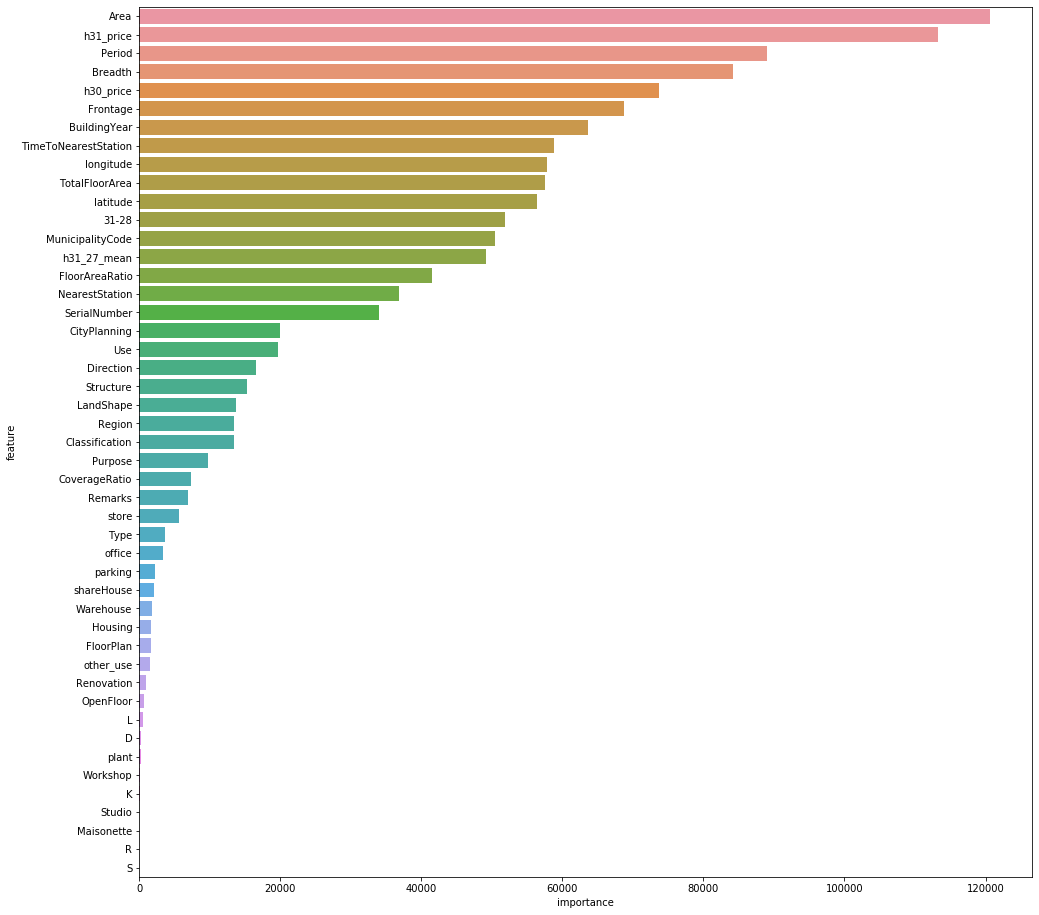

In [81]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [82]:
# y_pred  = model.predict(test, num_iteration=model.best_iteration)
y_pred_fi = y_pred / 4

In [83]:
y_pred_fi = np.round(y_pred_fi, 2)

In [84]:
y_pred_fi

array([ 24.86,  14.36, 247.75, ...,  10.89,  18.91,   9.15])

In [85]:
submit = pd.read_csv('input/test_data.csv')

In [86]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred_fi})

In [87]:
sub.to_csv('sub_lgbm_9.csv', index=False)